In [1]:
import os
import time
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
%matplotlib inline
%load_ext tensorboard
print(tf.__version__)
print(keras.__version__)
import warnings
warnings.filterwarnings('ignore')


2.6.0
2.6.0


In [2]:
fashion_dataset = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_dataset.load_data()

In [3]:
print("Train Data: ")
print(X_train_full.shape)
print(y_train_full.shape)
print("Testing Data: ")
print(X_test.shape)
print(y_test.shape)

print("=" * 50)
print(X_train_full[0])

Train Data: 
(60000, 28, 28)
(60000,)
Testing Data: 
(10000, 28, 28)
(10000,)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141

# From Loading Data

- Train data: 60000 instances which each instance represent image
- Test data: 10000
- (60000,) & (10000,) are rank-1 array labels (Target Variable).
- No Dev-set so we need to create one for validation
- 28 * 28 gray scale image so need to vectorize to feed to the model
- Image intensities have range from 0-255 as integer datatype so need scaling to 0-1

In [4]:
X_train, X_valid = X_train_full[:55000] / 255.0, X_train_full[55000:] / 255.0
y_train, y_valid = y_train_full[:55000], y_train_full[55000:]

## Display some images

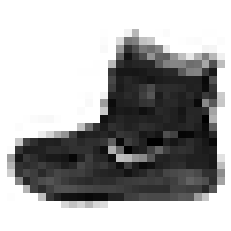

In [5]:
some_digit = X_train_full[0]
plt.imshow(some_digit, cmap='binary') # Binary to be in Gray scale
plt.axis('off')
plt.show()

In [6]:
# List class names to know which class we dealing with
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

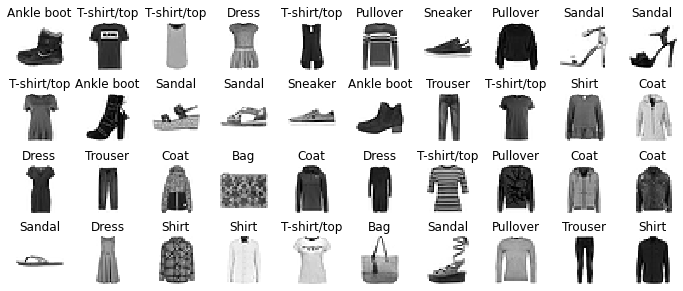

In [7]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


##  Creating The model Using the Sequential Keras API

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

## Another Way

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])

## Model Information

- keras.models.Sequential()
    - Create a sequential model (It stack layer by layer as sequential)
    
- keras.layers.Flatten(input_shape=[28, 28])

Add the input layer, Flatten means reshape the input image, and there is no batch size have been introduced so when we print the summary we will see for the (None, 784), none means that any number of instance(batch-size) can be feed to the input layer.

- keras.layers.Dense(300, activation='relu')

Create first hidden layer with 300 neurons and set the activation function with **Relu** function (linear function), **Dense** means that fully connected layer, and this hidden layer manage the matrix weights and the bias vectors.

- keras.layers.Dense(100, activation='relu') same but with 100 neurons

- keras.layers.Dense(10, activation='softmax')

As we dealing with 10-classes (multi classification task) do for the output layer we set the activation function to softmax which handle this by probability distribution for 10-class up to 1.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


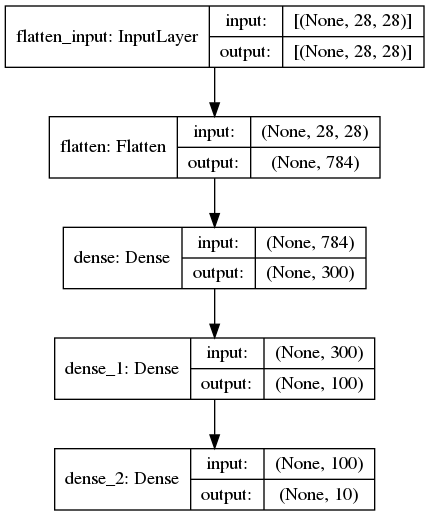

In [10]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

## Model summary

Its layer has its own name as you can see Flatten, dense_1 and so on.

The output shape of each layer is:

- Input layer (None, 784) None means you can feed any number of instance(batch-size), 784 after flate the input
- (None, 300), None will be the batch-size when you specify, 300 nurons
- (None, 300) and (None, 100) as above

The Param:

**Input layer has no params associated with it, it just represent the features we have**

We have just the weights and bais as our paramters so, the weighted matrix of first hidden layer and the bais vector is equal to:

- Number of nuorns in its layer * number of neurons in previous layer and this means 300 * nuorns of input layer for wieghted matrix, so 300 * 784

- Number of nuorns in its layer for bais vector, so 300 * 1
- summ (300 * 784 + 300) = 235500 as you can see in summary of first hidden layer

Just as above the next layer will be
- (100 * 300 + 100)  = 30100
- (10 * 100 + 10) = 1010
- Total of params along the network is 235500 + 30100 + 1010 = 266610


In [11]:
# get model list of layers
print(model.layers)
hidden1 = model.layers[1] # 1 as first hidden layers because layer 0 for the input layer
print("="*50)
print(hidden1.name)

[<keras.layers.core.Flatten object at 0x7fa464748c88>, <keras.layers.core.Dense object at 0x7fa46399b9e8>, <keras.layers.core.Dense object at 0x7fa463942eb8>, <keras.layers.core.Dense object at 0x7fa4601777b8>]
dense


In [12]:
# get the weights and the bias for this hidden layer
weights1, bais1 = hidden1.get_weights()
print(weights1.shape)
print(bais1.shape)
print(bais1)
weights1

(784, 300)
(300,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([[ 0.01855657, -0.02582928, -0.01116974, ..., -0.00986645,
        -0.02670331,  0.02857717],
       [-0.07176007,  0.02613346, -0.06925733, ...,  0.04578768,
        -0.01279071, -0.06861894],
       [-0.07159699,  0.01674688,  0.03190048, ..., -0.04001986,
        -0.00266774,  0.03071966],
       ...,
       [ 0.01381165, -0.04273189,  0.03212753, ..., -0.05961136,
         0.0124689 , -0.00037033],
       [ 0.06095718,  0.07171668,  0.06315157, ...,  0.06449686,
        -0.05781815,  0.06444739],
       [-0.05523137,  0.00675301,  0.0111271 , ...,  0.04634476,
        -0.0587753 , -0.01012485]], dtype=float32)

## From weights

As we can see bias initialized as vector of zeros while weights with random values to break the symmetry in learning.

## Complile & Fit the model

- loss

**sparse_categorical_crossentropy** when you have one class per instance from some of classes as from 0-9, while **categorical_crossentropy** when you have a one-hot for each instance and this one_hot vector is all of 0 and 1 for index that represent the class which this instance belong to.

- optimizer

As we can see sgd have no hyper parameters so it used the default defined ones from keras like for learning rate it use .01, so if we need to use what we need we have to pass **keras.optimizers.SGD(learning_rate=.01)** and other parameters it used.

- metrics
Is an optional parameters as others except the loss and the optimizer, and it give you the accuracy during each epoch as in the **Bar** and if you apply a validation set, at the end of each epoch it will give you the accuracy as well as the loss on this dev set.

Once we fit the model it give us the history during the journy of the model for each epochs from loss to accuracy as you apply other optional parameters in the compile it will give you history of these parameters.

So we can see th

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics="accuracy")

In [14]:
y_train[:3]

array([9, 0, 0], dtype=uint8)

In [15]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7107 - accuracy: 0.7664 - val_loss: 0.5155 - val_accuracy: 0.8178
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4892 - accuracy: 0.8309 - val_loss: 0.4441 - val_accuracy: 0.8434
Epoch 3/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4431 - accuracy: 0.8452 - val_loss: 0.4493 - val_accuracy: 0.8414
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4157 - accuracy: 0.8550 - val_loss: 0.4435 - val_accuracy: 0.8406
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3951 - accuracy: 0.8626 - val_loss: 0.3828 - val_accuracy: 0.8632
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3791 - accuracy: 0.8671 - val_loss: 0.3780 - val_accuracy: 0.8646
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3651 - accuracy: 0.8715 - val_loss: 0.3876 - val_accuracy:

## SGD

As we can see it pass not one instance at a time in the Bar it default is 32 as well as it wait to end of epoch to give you the loss and accuracy on validation set while it changes in the training

## Important NOTE from the book

""If the training set was very skewed, with some classes being overrepresented and others  underrepresented,  it  would  be  useful  to  set  the  class_weight  argument  when calling  the  fit()  method,  giving  a  larger  weight  to  underrepresented  classes,  and  alower weight to overrepresented classes. These weights would be used by Keras when computing  the  loss.  If  you  need  per-instance  weights  instead,  you  can  set  the  sample_weight  argument  (it  supersedes  class_weight).  This  could  be  useful  for  example  if  some  instances  were  labeled  by  experts  while  others  were  labeled  using  acrowd sourcing platform: you might want to give more weight to the former. You canalso  provide  sample  weights  (but  not  class  weights)  for  the  validation  set  by  addingthem as a third item in the validation_data tuple""



In [16]:
print(history.params)
print(history.epoch)

{'verbose': 1, 'epochs': 30, 'steps': 1719}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


(0.0, 1.0)

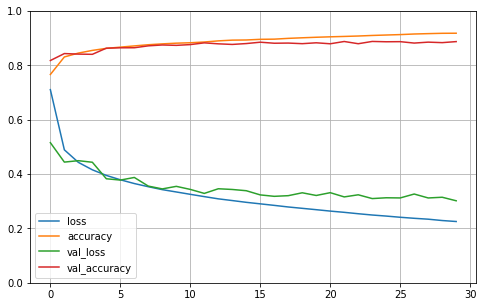

In [17]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

In [18]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2170 - accuracy: 0.9222


[0.2169802039861679, 0.9221636652946472]

In [19]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3018 - accuracy: 0.8874


[0.3017829656600952, 0.8873999714851379]

In [20]:
# one probabilty per class
x_new = X_test[:10]
model.predict(x_new)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [21]:
# predict class dierctly
y_pred = model.predict(x_new)
y_pred=np.argmax(y_pred,axis=1)

print(y_pred)
print(np.array(class_names)[y_pred])

[9 2 1 1 6 1 4 6 5 7]
['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt' 'Sandal' 'Sneaker']


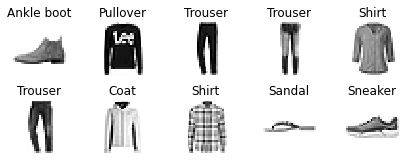

In [22]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(x_new):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Regression MLP

Now let going on another problem but regression problem to see how Keras APIs work also with regression problems.

In [23]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [25]:
X_train.shape

(11610, 8)

In [26]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.9005 - val_loss: 0.5108
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4776 - val_loss: 0.4260
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4429 - val_loss: 0.4175
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4303 - val_loss: 0.3985
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4225 - val_loss: 0.3871
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4153 - val_loss: 0.3931
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4077 - val_loss: 0.3829
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4034 - val_loss: 0.3919
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4007 - val_loss: 0.3745
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3971 - val_loss: 0.3735

array([[2.4064276],
       [2.8560443],
       [1.301703 ]], dtype=float32)

In [27]:
mse_test

0.36361613869667053

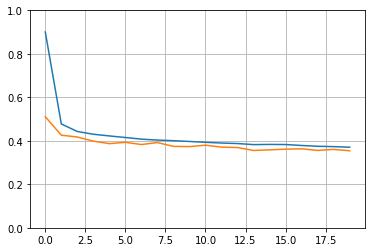

In [28]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Building Complex Models Using the Functioal APIs

As you can see, the Sequential API is quite easy to use. However, although sequential models are extremely common, it is sometimes useful to build neural networks with more complex topologies, or with multiple inputs or outputs. For this purpose, Kerasoffers the Functional API.

This architecture using all or part from the features as a **wide** which path directly to the output layer, and at the same time part or all the features during the **deep** path, it helps the model to learn from deep patterns as well as from directly the input features because it sometimes these features distorted by this sequence if transformation during the deep path.

<img src="images/ch10_1.png" width="300" height="300">

First,  we  need  to  create  an  Input  object.  This  is  needed  because  we  may  have multiple inputs, as we will see later.

Notice that we call it like a function, passing it the input. This is why this is called the Functional API. Note that we are just telling Keras how it should connect the layers together, no actual data is being pro‐cessed yet.

Next, path the hidden1 to hidden2 as well.

Next, we create a Concatenate() to  concatenate  the  input  and  the  output  of  the  second  hidden  layer.

Next, the path the result from the concatenation of input(simple rules), and deeply hidden path (deep pattern) to the output layer.

Next, build the keras model from these wide and deep representation, which specifying inputs and outputs to use.

In [29]:
X_train.shape

(11610, 8)

In [30]:
input_  = keras.layers.Input(shape=X_train.shape[1])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat  = keras.layers.concatenate([input_, hidden2])
output  = keras.layers.Dense(1)(concat)
model   = keras.Model(inputs=[input_], outputs=[output]) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [31]:
model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.1017 - val_loss: 13.0537
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 5.3609 - val_loss: 718.6829
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 24.3263 - val_loss: 1264.3297
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 11/20
363/363 [=============

array([[nan],
       [nan],
       [nan]], dtype=float32)

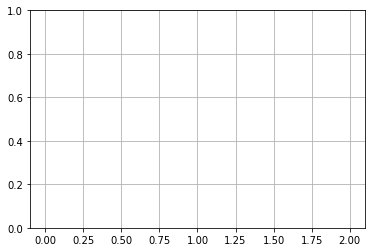

In [32]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# multiple  inputs
But  what  if  you  want  to  send  a  subset  of  the  features  through  the  wide  path,  and  a different  subset  (possibly  overlapping)  through  the  deep  path In this  case,  one  solution  is  to  use  **multiple  inputs.**  For  example,  suppose  we  want  tosend  5  features  through  the  deep  path  (features  0  to  4),  and  6  features  through  the wide path (features 2 to 7).

<img src="images/ch10_2.png" width="300" height="300">

In [33]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input") 
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='output')(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

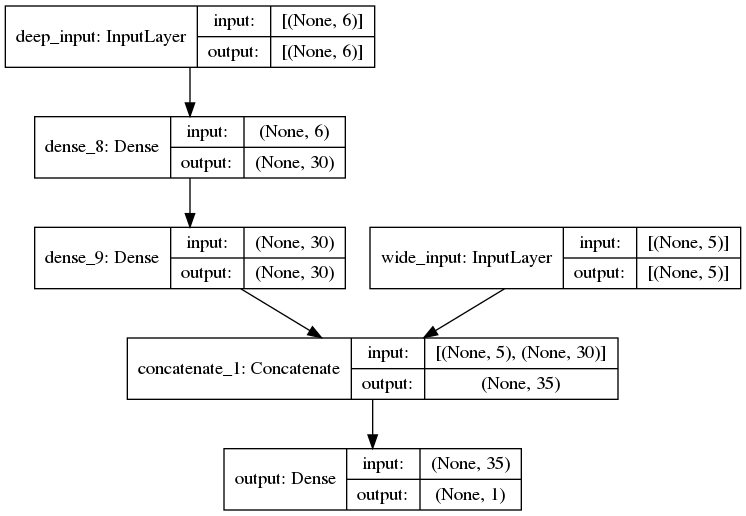

In [34]:
keras.utils.plot_model(model, "my_fashion_mnist_model2.png", show_shapes=True)

Note  that  we  specified  inputs=[input_A,  input_B], when creating the model. Now we can compile the model as usual, but when we call the  fit()  method,  instead  of  passing  a  single  input  matrix  X_train,  we  must  pass  a pair  of  matrices  (X_train_A,  X_train_B):  one  per  input.  The  same  is  true  for X_valid, and also for X_test and X_new when you call evaluate() or predict():

In [35]:
X_train_A, X_train_B  = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B  = X_valid[:, :5], X_valid[:, 2:]
X_test_A,  X_test_B   = X_test[:, :5],  X_test[:, 2:]
X_new_A,   X_new_B    = X_test_A[:3], X_test_B[:3]

model.compile(loss="mean_squared_error", optimizer='sgd')

history = model.fit((X_train_A, X_train_B), y_train, epochs=10,
                    validation_data=((X_valid_A, X_valid_B ), y_valid))

mse_test = model.evaluate((X_test_A,  X_test_B), y_test)
y_pred = model.predict((X_new_A,   X_new_B ))
print(mse_test)
print(y_pred)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.1111 - val_loss: 0.5061
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4863 - val_loss: 0.7180
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4883 - val_loss: 0.5074
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4377 - val_loss: 0.4068
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4208 - val_loss: 0.3978
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.3871
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4060 - val_loss: 0.3788
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3998 - val_loss: 0.3784
Epoch 9/10
363/363 [==============================] - 1s 1ms/step - loss: 0.3956 - val_loss: 0.3971
Epoch 10/10
162/162 [==============================] - 0s 922us/step - loss: 0.3734
0.37344190478324

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           930         dense_8[0][0]                    
____________________________________________________________________________________________

# multiple  output

One of the favorite thing in the functional API, its provide us if we need to handle multi-task classification, or even if we work on the dataset and we have to classify something is discrete and another output is regression, or even if we need multi-output for the same thing as we will see.

<img src="images/ch10_3.png" width="300" height="300">

In [37]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat  = keras.layers.concatenate([input_A, hidden2])

# All of the above lines as before with multi input idea
output     = keras.layers.Dense(1, name='main_output')(concat)

# The new output aux output and its not complex as the other one and maybe it possible in regularization
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)

# Now the model has two output and when compile need output y for each of them
model      = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])


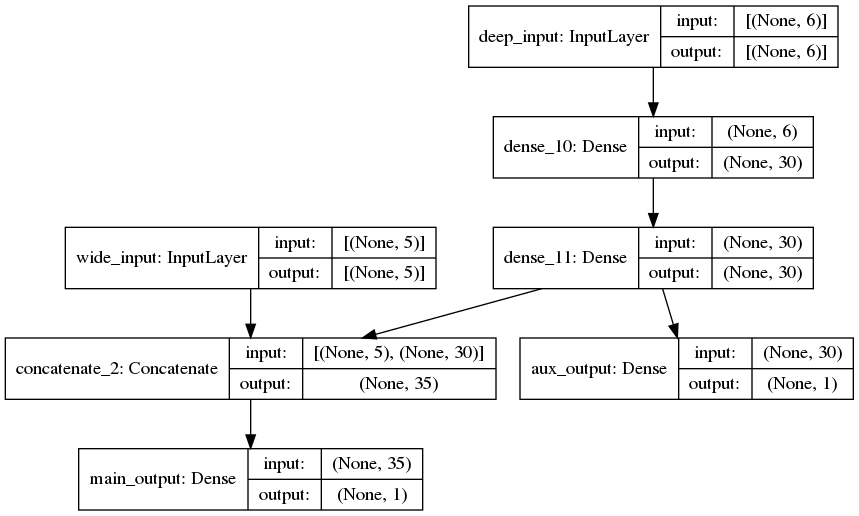

In [38]:
keras.utils.plot_model(model, "my_fashion_mnist_model2.png", show_shapes=True)

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 30)           930         dense_10[0][0]                   
____________________________________________________________________________________________

# Notes !
we  care  much more about the main output than about the auxiliary output (as it is just used for reg‐ularization), so we want to give the main output’s loss a much greater weight

In [40]:
model.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], optimizer='sgd')

The main output and the auxiliary output should try to predict the samething, so they should use the same labels. So instead of passing y_train, we just needto pass (y_train, y_train) 

In [41]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
          validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9631 - main_output_loss: 0.8733 - aux_output_loss: 1.7717 - val_loss: 0.7443 - val_main_output_loss: 0.6808 - val_aux_output_loss: 1.3163
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5848 - main_output_loss: 0.5313 - aux_output_loss: 1.0659 - val_loss: 0.6093 - val_main_output_loss: 0.5690 - val_aux_output_loss: 0.9717
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5203 - main_output_loss: 0.4792 - aux_output_loss: 0.8901 - val_loss: 0.4980 - val_main_output_loss: 0.4662 - val_aux_output_loss: 0.7840
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4801 - main_output_loss: 0.4472 - aux_output_loss: 0.7768 - val_loss: 0.4739 - val_main_output_loss: 0.4465 - val_aux_output_loss: 0.7208
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4688 - main_output_loss: 0.4417 - aux_output_loss: 0.7130 - val_loss

(0.0, 1.0)

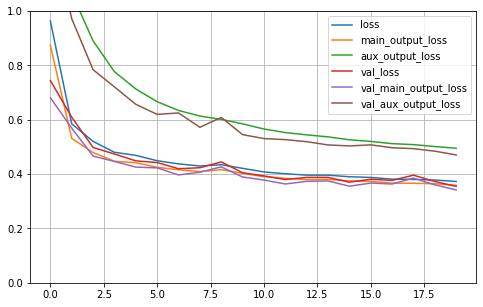

In [42]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)


In [43]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
print('======================')
print(total_loss)
print(main_loss)
print(aux_loss)

162/162 [==============================] - 0s 931us/step - loss: 0.3546 - main_output_loss: 0.3414 - aux_output_loss: 0.4742
0.3546464145183563
0.3413594365119934
0.4742293059825897


In [44]:
# Similarly, the predict() method will return predictions for each output
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

In [45]:
y_pred_main[:5]

array([[2.1323462],
       [2.7336366],
       [1.4170306]], dtype=float32)

In [46]:
y_pred_aux[:5]

array([[2.0582743],
       [2.3761377],
       [1.5503141]], dtype=float32)

# Using the Subclassing API to Build Dynamic Models 

**I think this point should be from the book dierct so I mentioned it as it in the book
**

Both the Sequential API and the Functional API are declarative: you start by declaring  which  layers  you  want  to  use  and  how  they  should  be  connected,  and  only  then can  you  start  feeding  the  model  some  data  for  training  or  inference.  This  has  many advantages:  the  model  can  easily  be  saved,  cloned,  shared,  its  structure  can  be  displayed  and  analyzed,  the  framework  can  infer  shapes  and  check  types,  so  errors  canbe caught early (i.e., before any data ever goes through the model). It’s also fairly easyto debug, since the whole model is just a static graph of layers. But the flip side is just that:  it’s  static.  Some  models  involve  loops,  varying  shapes,  conditional  branching,and other dynamic behaviors. For such cases, or simply if you prefer a more impera‐tive programming style, the Subclassing API is for you.

Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. For example, creating  an  instance  of  the  following  WideAndDeepModel  class  gives  us  an  equivalent model to the one we just built with the Functional API. You can then compile it, eval‐uate it and use it to make predictions, exactly like we just did.

But, this  extra  flexibility  comes  at  a  cost:  your  model’s  architecture  is  hidden within the call() method, so Keras cannot easily inspect it, it cannot save or clone it,and  when  you  call  the  summary()  method,  you  only  get  a  list  of  layers,  without  any information on how they are connected to each other. Moreover, Keras cannot checktypes and shapes ahead of time, and it is easier to make mistakes. So unless you really need  that  extra  flexibility,  you  should  probably  stick  to  the  Sequential  API  or  theFunctional API.

# Note !

The inheritance design in the subclass usage of the **Model** class provide you with the public methods in the super class.

In [47]:
# class WideAndDeepModel(keras.Model):
#     def __init__(self, units=30, activation='relu', **kwargs):
#         super().__init__(**kwargs) ## handles standards args like: name
#         self.hidden1 = keras.layers.Dense(units, activation=activation)
#         self.hidden2 = keras.layers.Dense(units, activation=activation)
#         self.main_output = keras.layers.Dense(1)
#         self.aux_output = keras.layers.Dense(1)
        
#     def call(self, inputs):
#         input_A, input_B = inputs
#         hidden1 = self.hidden1(input_B)
#         hidden2 = self.hidden2(hidden1)
#         concat = keras.layers.concatenate([input_A, hidden2])
#         main_output = self.main_output(concat)
#         aux_loss = self.aux_output(hidden2)
#         return main_output, aux_output
    
# model = WideAndDeepModel()


In [48]:
model.save('models/first_keras_model.h5')

In [49]:
model = keras.models.load_model('models/first_keras_model.h5')

# Again after load the model 
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
print('======================')
print(total_loss)
print(main_loss)
print(aux_loss)

162/162 [==============================] - 0s 1ms/step - loss: 0.3546 - main_output_loss: 0.3414 - aux_output_loss: 0.4742
0.3546464145183563
0.3413594365119934
0.4742293059825897


# Using Callbacks

Its regular when the dataset becomes large and large that your model may take days or hours of run and in this case you do not need to wait to save the model at the end of training because of case that computer crashes or networks problems and others and for this we have to save checkpoints during the training on regular intervals.

Callbacks have different functionality from checkpoints saved to early stopping and others as well it help you to design your callbacks function, checkpoints used when your computer crash or others problem to save your models and the paramters **save_best_only** to retrive and save the weights based on the best score on the validation, and for early stoping when the val_loss across diferent eopchs in our case **10 epochs** and no progress have made it stop the learning.

In [50]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [51]:
X_train.shape

(11610, 8)

In [52]:
model = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=["accuracy"])

filepath = "models/saved-model-{epoch:02d}-{val_loss:.2f}.h5"

checkpoints_cb = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

history = model.fit(X_train, y_train, epochs=20, validation_split=0.2,
                   callbacks=[checkpoints_cb])

Epoch 1/20
291/291 [==============================] - 1s 2ms/step - loss: 1.1270 - accuracy: 0.0030 - val_loss: 0.6206 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from -inf to 0.62058, saving model to models/saved-model-01-0.62.h5
Epoch 2/20
291/291 [==============================] - 0s 1ms/step - loss: 0.6023 - accuracy: 0.0031 - val_loss: 0.5304 - val_accuracy: 0.0022

Epoch 00002: val_loss did not improve from 0.62058
Epoch 3/20
291/291 [==============================] - 0s 1ms/step - loss: 0.5287 - accuracy: 0.0031 - val_loss: 0.4783 - val_accuracy: 0.0022

Epoch 00003: val_loss did not improve from 0.62058
Epoch 4/20
291/291 [==============================] - 0s 1ms/step - loss: 0.4936 - accuracy: 0.0031 - val_loss: 0.4524 - val_accuracy: 0.0022

Epoch 00004: val_loss did not improve from 0.62058
Epoch 5/20
291/291 [==============================] - 0s 1ms/step - loss: 0.4691 - accuracy: 0.0030 - val_loss: 0.4342 - val_accuracy: 0.0022

Epoch 00005: val_loss did not imp

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='sgd')

filepath = "models/saved-model-EarlyStopping-{epoch:02d}-{val_loss:.2f}.h5"

checkpoints_cb = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
earlyStopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                   callbacks=[checkpoints_cb, earlyStopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.8780 - val_loss: 3.8537

Epoch 00001: val_loss improved from inf to 3.85375, saving model to models/saved-model-EarlyStopping-01-3.85.h5
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 1.0096 - val_loss: 7.8806

Epoch 00002: val_loss did not improve from 3.85375
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7923 - val_loss: 0.7921

Epoch 00003: val_loss improved from 3.85375 to 0.79208, saving model to models/saved-model-EarlyStopping-03-0.79.h5
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4599 - val_loss: 0.4096

Epoch 00004: val_loss improved from 0.79208 to 0.40961, saving model to models/saved-model-EarlyStopping-04-0.41.h5
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4218 - val_loss: 0.3981

Epoch 00005: val_loss improved from 0.40961 to 0.39814, saving model to models/saved-model-Earl

# Using Tensorboard for visulization


""
TensorBoard  is  a  great  interactive  visualization  tool  that  you  can  use  to  view  thelearning curves during training, compare learning curves between multiple runs, vis‐ualize  the  computation  graph,  analyze  training  statistics,  view  images  generated  byyour  model.
""
""
To use it, you must modify your program so that it outputs the data you want to visu‐alize  to  special  binary  log  files  called  event  files.  Each  binary  data  record  is  called  asummary. The TensorBoard server will monitor the log directory, and it will automat‐ically  pick  up  the  changes  and  update  the  visualizations:  this  allows  you  to  visualizelive data (with a short delay), such as the learning curves during training. In general,you want to point the TensorBoard server to a root log directory, and configure yourprogram so that it writes to a different subdirectory every time it runs. This way, thesame TensorBoard server instance will allow you to visualize and compare data frommultiple runs of your program, without getting everything mixed up""

In [54]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


In [55]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),
                   callbacks=[tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 1.0465 - val_loss: 2.8469
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3627 - val_loss: 2.2485
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5310 - val_loss: 33.4930
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.7827 - val_loss: 0.4382
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3985 - val_loss: 0.3605
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3789 - val_loss: 0.3525
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3718 - val_loss: 0.3483
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3675 - val_loss: 0.3412
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3634 - val_loss: 0.3397
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3603 - val_loss: 0.357

# Fine-Tuning Neural Network Hyperparameters

FeedForward and BackdAll of these hyperparameters introduce a question of How  do  you  know  what  combination  of  hyperparameters is the best for your task, using **sklearn** GridSearch for brute force combination or RandomSearch is not the best way, but Keras wrapper provides a way to go beyond this.

The first step is to create a func‐tion that will build and compile a Keras model, given a set of hyperparameters.

In [56]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=learning_rate))
    return model

# Now, let’s create a KerasRegressor based on this build_model()

In [57]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

**The  KerasRegressor  object  is  a  thin  wrapper  around  the  Keras  model  built  usingbuild_model(). Since we did not specify any hyperparameter when creating it, it willjust  use  the  default  hyperparameters  we  defined  in  build_model(). **

 Now  we  can  use this  object  like  a  regular  Scikit-Learn  regressor:  we  can  train  it  using  its  fit()method,  then  evaluate  it  using  its  score()  method,  and  use  it  to  make  predictions using  its  predict()  method.  Note  that  any  extra  parameter  you  pass  to  the  fit()method  will  simply  get  passed  to  the  underlying  Keras  model.  

In [58]:
keras_reg.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
mse_test

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.4010 - val_loss: 0.6866
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6724 - val_loss: 0.5845
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5930 - val_loss: 0.5285
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5431 - val_loss: 0.4875
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5087 - val_loss: 0.4613
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4853 - val_loss: 0.4429
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4681 - val_loss: 0.4316
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4548 - val_loss: 0.4214
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4448 - val_loss: 0.4155
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4365 - val_loss: 0.4107

-0.38279902935028076

However,  we  do  not  actually  want  to  train  and  evaluate  a  single  model  like  this,  we want to train hundreds of variants and see which one performs best on the validation set. Since there are many hyperparameters, it is preferable to use a randomized search.

In [59]:
# Now we can use any combination of hyperparams using this regressor 
#instead of the default defined in the build method
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
param_distribs = {"n_hidden": [0, 1, 2, 3],   
                  "n_neurons": np.arange(1, 100),
                  "learning_rate": reciprocal(3e-4, 3e-2),}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
242/242 [==============================] - 1s 2ms/step - loss: 1.1203 - val_loss: 0.7059
Epoch 2/10
242/242 [==============================] - 0s 1ms/step - loss: 0.6446 - val_loss: 5.2419
Epoch 3/10
242/242 [==============================] - 0s 1ms/step - loss: 0.7565 - val_loss: 0.9249
Epoch 4/10
242/242 [==============================] - 0s 1ms/step - loss: 0.5120 - val_loss: 0.5819
Epoch 5/10
242/242 [==============================] - 0s 1ms/step - loss: 0.4524 - val_loss: 0.4075
Epoch 6/10
242/242 [==============================] - 0s 1ms/step - loss: 0.4306 - val_loss: 0.4034
Epoch 7/10
242/242 [==============================] - 0s 1ms/step - loss: 0.4188 - val_loss: 0.3888
Epoch 8/10
242/242 [==============================] - 0s 1ms/step - loss: 0.4107 - val_loss: 0.3925
Epoch 9/10
242/242 [==============================] - 0s 1ms/step - loss: 0.4042 - val_loss: 0.3807
Epoch 10/10
121/121 [==============================] - 0s 805us/step - loss: 0.3850
Epoch 1/10
242/2

Epoch 8/10
242/242 [==============================] - 0s 1ms/step - loss: 0.6487 - val_loss: 1.8218
Epoch 9/10
242/242 [==============================] - 0s 1ms/step - loss: 0.6323 - val_loss: 1.5785
Epoch 10/10
121/121 [==============================] - 0s 776us/step - loss: 0.7184
Epoch 1/10
242/242 [==============================] - 1s 2ms/step - loss: 3.1197 - val_loss: 1.5536
Epoch 2/10
242/242 [==============================] - 0s 1ms/step - loss: 1.1362 - val_loss: 0.8459
Epoch 3/10
242/242 [==============================] - 0s 1ms/step - loss: 0.8051 - val_loss: 0.7070
Epoch 4/10
242/242 [==============================] - 0s 1ms/step - loss: 0.7298 - val_loss: 0.6646
Epoch 5/10
242/242 [==============================] - 0s 1ms/step - loss: 0.6969 - val_loss: 0.6406
Epoch 6/10
242/242 [==============================] - 0s 1ms/step - loss: 0.6729 - val_loss: 0.6251
Epoch 7/10
242/242 [==============================] - 0s 1ms/step - loss: 0.6521 - val_loss: 0.6043
Epoch 8/10
242/2

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa47ad88d30>,
                   n_iter=5,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa47ad88cf8>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

**we pass extra parameters to the fit() method: they simply get relayed to the under‐lying Keras models**

In [60]:
def build_model(n_hidden=0, n_neurons=0, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=learning_rate))
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
param_distribs = {"learning_rate": np.linspace(0.005, 3, 10).astype('float16')}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=3)])

ValueError: Please provide to Input a `shape` or a `tensor` or a `type_spec` argument. Note that `shape` does not include the batch dimension.

In [ ]:
learning_rate= np.linspace(0.005, 3, 10).astype('float16')
learning_rate

# NOTEs from the book !!

However,  when  training  is  slow(e.g.,  for  more  complex  problems  with  larger  datasets),  this  approach  will  onlyexplore  a  tiny  portion  of  the  hyperparameter  space, but we  can  partially  alleviate  this problem  by  assisting  the  search  process  manually:  first  run  a  quick  random  search using  wide  ranges  of  hyperparameter  values,  then  run  another  search  using  smaller ranges of values centered on the best ones found during the first run, and so on.
 
This will  hopefully  zoom  in  to  a  good  set  of  hyperparameters.  However,  this  is  very  time consuming, and probably not the best use of your time.

Fortunately,  there  are  many  techniques  to  explore  a  search  space  much  more  effi‐ciently than randomly.

Their core idea is simple: when a region of the space turns out to be good, it should be explored more. This takes care of the “zooming” process foryou  and  leads  to  much  better  solutions  in  much  less  time.  Here  are  a  few  Python libraries you can use to optimize hyperparameters:

- Hyperopt
- Hyperas,  kopt  or  Talos
- Scikit-Optimize and others

# Number of Hidden layers

What the number of hidden layers should we use ? it's like a magic box even of that one-hidden layer make a good prediction at some problems, but with the complexity of the dataset like the recognized pictures the deep network can do magic things, because low-level layers capture the edges (lines like horizontal and verticals), second-level which the medium layers trying tom combine these edges to make shapes which will be used in the last layer to identify the faces with the output layers.

We can use the weights of low-level layers as pre-trained parameters for some problem and map to the similar problem we have (transfer learning), as low-level in similar problem will capture the similar things, and by training, it will change according to the new problem we transfer to.

# Number of neurons per hidden layers

The neurons per input and output layers are defined by the problem itself like in an image the input layer neurons will be the width * height of that image, and the output depends on the case if you classify or detect objects and so on.

But this is different when we dealing with hidden layers, the number of neurons plays the role that can get the features representation and in the high-level layer, the neurons be responsible for combine some of the features together in one neuron-like part of the face and other neurons for another part and in the neurons of next layers, these parts combined together and so on, also if we have just 2 neurons in first hidden layers with 3-d problems it will be lost some of the information so it important, but for most cases we use a big number of layers and neurons for each layer become small as we go deeper, and in the problem of overfitting we can doing dropout, regularization or even change the architecture.

# Try to solve chapter Exercise